# Preparations

## Loading packages

In [4]:
!pip install qiskit qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.5 MB/s eta 0:00:00


In [5]:
from itertools import combinations, permutations, groupby
import networkx as nx
from networkx.algorithms.approximation import one_exchange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix

## Graph generator

In [ ]:
"""
generate all subsets
"""
def subsets(ls):
        res = []
        def dfs(i, subset):
            # base case
            if i == len(ls):
                res.append(subset.copy())
                return

            dfs(i + 1, subset)

            subset.append(ls[i])
            dfs(i + 1, subset)
            subset.pop()

        dfs(0, [])
        return res


"""
check if graph g1 is isomorphic to any graph in the list
"""
def is_unique(ls, g1):
    if not ls:
        return True
    for g2 in ls:
        if nx.is_isomorphic(g1, g2):
            return False
    return True

def ErdosEdwards(n, m):  # num of vertices and num of edges
    return int(np.ceil((2 * m + n - 1)/4))

def get_graph_data(G):
    GraphLaplacian = np.array(nx.laplacian_matrix(G).toarray())
    NumberOfVerticies, NumberOfEdges = G.number_of_nodes(), G.number_of_edges()
    threshold = ErdosEdwards(NumberOfEdges, NumberOfVerticies)

    maxdegvertex = np.where(np.diag(GraphLaplacian) == max(np.diag(GraphLaplacian)))[0][0]
    if maxdegvertex + 1 != NumberOfVerticies:
        GraphLaplacian[[maxdegvertex, -1], :] = GraphLaplacian[[-1, maxdegvertex], :]
        GraphLaplacian[:, [maxdegvertex, -1]] = GraphLaplacian[:, [-1, maxdegvertex]]
    QuadraticForm = GraphLaplacian[np.ix_(np.arange(NumberOfVerticies - 1), np.arange(NumberOfVerticies - 1))]

    # cut-function and MaxCut
    cuts, MaxCut = {0: 0}, 0
    for x in range(1, pow(2, len(QuadraticForm))):
        conf = np.array([(x >> i)&1 for i in range(len(QuadraticForm))])
        cuts[x] = np.matmul(conf, np.matmul(QuadraticForm, np.transpose(conf)))
        MaxCut = max(MaxCut, cuts[x])

    # cut disctibution and ratios
    random_chance, Lambda, dp = {i: 0 for i in range(MaxCut + 1)}, 0, pow(2, 1 - NumberOfVerticies)
    for _, cut in cuts.items():
        random_chance[cut] += dp
        if cut >= threshold:
            Lambda += dp

    return QuadraticForm, threshold, Lambda, random_chance

In [ ]:
"""
returns {graph: multiplicity}
"""
def generate_connected_graphs(n):  # n vertices
    all_edges = list(combinations(range(n), 2))
    edge_subsets = [i for i in subsets(all_edges) if len(i) >= n - 1] # rule out the obvious cases
    res = {}

    for subset in edge_subsets:
        G = nx.Graph()
        G.add_nodes_from(range(n))
        G.add_edges_from(subset)

        if nx.is_connected(G):
            if is_unique(list(res.keys()), G):
                    res[G] = 1
            else:
                for k in res.keys():
                    if nx.is_isomorphic(k, G):
                        res[k] += 1
                        break

    return res

## Simulator

In [ ]:
# L, x must be positive
def Chebyshev(L:  float, x: float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

# delta, Lambda must be in (0, 1)
def GroverQueryComplexity(delta: float, Lambda: float):
    return int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2

# delta, Lambda must be in (0, 1)
def GroverProbability(delta: float, Lambda: float):
    L = 2 * GroverQueryComplexity(delta, Lambda) + 1
    return 1 - pow(delta * Chebyshev(L, Chebyshev(1 / L, 1 / delta) * np.sqrt(1 - Lambda)), 2)

# P, Lambda must be in (0, 1), N must be a positive integer
def GroverParameterOptimizer(P: float, Lambda: float, N: int):
    step, L, p = pow(2, - N), 0, 0
    done = False
    while p < P:
        L += 1
        d = step
        l = GroverQueryComplexity(d, Lambda)
        while l > L:
            d += step
            l = GroverQueryComplexity(d, Lambda)
        delta = d
        while d < 1:
            p_new = GroverProbability(d, Lambda)
            if p_new >= p:
                p, delta = p_new, d
            d += step
            l = GroverQueryComplexity(d, Lambda)

    return delta, GroverQueryComplexity(delta, Lambda), GroverProbability(delta, Lambda)

In [ ]:
def Grover(G, m, QuadraticForm, threshold, Lambda, random_chance, P):
    delta, l, P = GroverParameterOptimizer(P, Lambda, 10)
    gamma = pow(1 - pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), - 2), - 1/2)
    GroverAngles = [2 * np.arctan(gamma / np.tan(2 * np.pi * j / (2 * l + 1))) for j in range(1, l + 1)]

    # quantum registers for the bit configurations
    QRegX = QuantumRegister(len(QuadraticForm), "x")

    NumberOfEdges = int((np.sum(QuadraticForm) + np.trace(QuadraticForm))/2)

    digits = 1 + int(np.ceil(np.log2(max(threshold, NumberOfEdges + 1 - threshold))))

    # quantum registers to digitize values
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX[:] + QRegY[:])

    # adding threshold - offset; the offset could have gone to later parts of the code, but this it's cheaper this way
    theta = (threshold - 1/2 - (np.sum(QuadraticForm) + np.trace(QuadraticForm))/4) * np.pi
    for i, q in enumerate(reversed(QRegY)):
        QC.rz(theta - np.pi/2, q)
        theta /= 2

    for alpha, beta in zip(GroverAngles, reversed(GroverAngles)):

        # S_t (beta)
        for i, p in enumerate(QRegX):

            if np.sum(QuadraticForm[i]) != 0:
                theta = np.sum(QuadraticForm[i]) * np.pi
                for q in reversed(QRegY):
                    QC.cx(p, q)
                    theta /= 2
                    QC.rz(theta, q)
                    QC.cx(p, q)

            for j, r in enumerate(QRegX[i + 1:]):
                if QuadraticForm[i][i + 1 + j] != 0:
                    QC.cx(p, r)
                    theta = QuadraticForm[i][i + 1 + j] * np.pi
                    for q in reversed(QRegY):
                        QC.cx(r, q)
                        theta /= 2
                        QC.rz(- theta, q)
                        QC.cx(r, q)
                    QC.cx(p, r)

        for i, q in enumerate(reversed(QRegY[1:])):
            QC.h(q)
            for j, r in enumerate(QRegY[:len(QRegY) - 1 - i]):
                QC.cx(q, r)
                QC.rz(pow(2, i + j - digits) * np.pi, r)
            for r in QRegY[:len(QRegY) - 2 - i]:
                QC.cx(q, r)

        QC.rx(beta, QRegY[0])

        for i, q in enumerate(QRegY[1:]):
            for r in reversed(QRegY[:i]):
                QC.cx(q, r)
            theta = np.pi / 2
            for r in reversed(QRegY[:i+1]):
                theta /= 2
                QC.rz(- theta, r)
                QC.cx(q, r)
            QC.h(q)

        for i, p in enumerate(reversed(QRegX)):

            for j, r in enumerate(reversed(QRegX[len(QRegX) - i:])):
                if QuadraticForm[- i - 1][- j - 1] != 0:
                    QC.cx(p, r)
                    theta = QuadraticForm[- i - 1][- j - 1] * np.pi
                    for q in reversed(QRegY):
                        theta /= 2
                        QC.cx(r, q)
                        QC.rz(theta, q)
                        QC.cx(r, q)
                    QC.cx(p, r)

            if np.sum(QuadraticForm[- i - 1]) != 0:
                theta = np.sum(QuadraticForm[- i - 1]) * np.pi
                for q in reversed(QRegY):
                    theta /= 2
                    QC.cx(p, q)
                    QC.rz(- theta, q)
                    QC.cx(p, q)

        # S_s (alpha)
        QC.ry(np.pi/2, QRegX)
        QC.mcp(alpha, QRegX[1:], QRegX[0])
        QC.ry(- np.pi/2, QRegX)

        QC.save_statevector()
        simulator = AerSimulator(method="statevector")
        psi = Statevector(execute(QC, simulator).result().get_statevector())

        return [G, m, QuadraticForm, threshold, Lambda, random_chance, P, psi, QC.depth(), QC.count_ops()]

# Run computations

In [ ]:
graphs = generate_connected_graphs(6)
# Graph, multiplicity, QuadraticForm, threshold, Lambda, random_chance
graphs_data = [(G, m) + get_graph_data(G) for (G, m) in graphs.items()]

results, P, total = [], 0.9, len(graphs_data)

for i, (G, m, QuadraticForm, threshold, Lambda, random_chance) in enumerate(graphs_data):
        results.append(Grover(G, m, QuadraticForm, threshold, Lambda, random_chance, P))
        print(f"done with {i + 1} out or {total}")

done with 1 out or 112
done with 2 out or 112
done with 3 out or 112
done with 4 out or 112
done with 5 out or 112
done with 6 out or 112
done with 7 out or 112
done with 8 out or 112
done with 9 out or 112
done with 10 out or 112
done with 11 out or 112
done with 12 out or 112
done with 13 out or 112
done with 14 out or 112
done with 15 out or 112
done with 16 out or 112
done with 17 out or 112
done with 18 out or 112
done with 19 out or 112
done with 20 out or 112
done with 21 out or 112
done with 22 out or 112
done with 23 out or 112
done with 24 out or 112
done with 25 out or 112
done with 26 out or 112
done with 27 out or 112
done with 28 out or 112
done with 29 out or 112
done with 30 out or 112
done with 31 out or 112
done with 32 out or 112
done with 33 out or 112
done with 34 out or 112
done with 35 out or 112
done with 36 out or 112
done with 37 out or 112
done with 38 out or 112
done with 39 out or 112
done with 40 out or 112
done with 41 out or 112
done with 42 out or 112
d

In [ ]:
# [G, m, QuadraticForm, threshold, Lambda, random_chance, P, psi, QC.depth(), QC.count_ops()]
multiplicities = [result[1] for result in results]
M = np.sum(multiplicities)

In [ ]:
lambdas = [result[4] for result in results]

In [ ]:
dist_L = {}
for l, m in zip(lambdas, multiplicities):
    if l in dist_L:
        dist_L[l] += m / M
    else:
        dist_L[l] = m / M

In [ ]:
L = np.sum([l * dist_L[l] for l in dist_L])
sigma_L = np.sqrt(np.sum([pow(l - L, 2) * dist_L[l] for l in dist_L]))
L, sigma_L

(0.356004718394248, 0.1733037077233942)

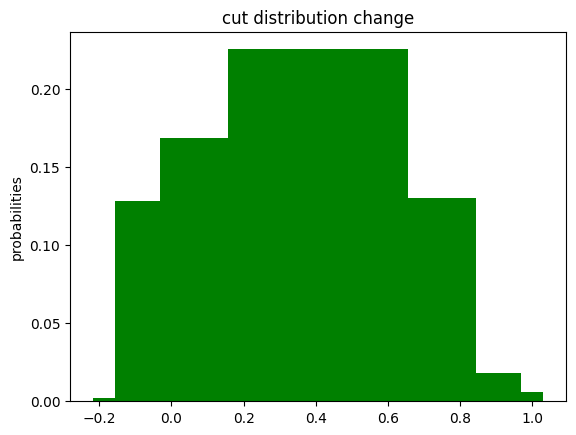

In [ ]:
plt.bar(dist_L.keys(),
        dist_L.values(),
        width=0.5,
        color="green")
plt.title(f"cut distribution change")
plt.ylabel(f"probabilities")
plt.show()

In [ ]:
lambdas

[0.1875,
 0.1875,
 0.09375,
 0.1875,
 0.1875,
 0.09375,
 0.09375,
 0.21875,
 0.09375,
 0.21875,
 0.40625,
 0.09375,
 0.21875,
 0.1875,
 0.09375,
 0.09375,
 0.1875,
 0.09375,
 0.09375,
 0.21875,
 0.21875,
 0.40625,
 0.15625,
 0.40625,
 0.28125,
 0.15625,
 0.21875,
 0.40625,
 0.09375,
 0.28125,
 0.21875,
 0.40625,
 0.34375,
 0.59375,
 0.09375,
 0.15625,
 0.21875,
 0.40625,
 0.21875,
 0.34375,
 0.21875,
 0.40625,
 0.59375,
 0.53125,
 0.34375,
 0.53125,
 0.4375,
 0.40625,
 0.59375,
 0.4375,
 0.625,
 0.15625,
 0.65625,
 0.09375,
 0.46875,
 0.21875,
 0.21875,
 0.34375,
 0.59375,
 0.53125,
 0.40625,
 0.03125,
 0.28125,
 0.40625,
 0.40625,
 0.21875,
 0.40625,
 0.59375,
 0.34375,
 0.53125,
 0.40625,
 0.34375,
 0.59375,
 0.53125,
 0.40625,
 0.34375,
 0.59375,
 0.28125,
 0.46875,
 0.40625,
 0.59375,
 0.59375,
 0.65625,
 0.40625,
 0.53125,
 0.59375,
 0.46875,
 0.53125,
 0.40625,
 0.40625,
 0.59375,
 0.71875,
 0.71875,
 0.5,
 0.40625,
 0.59375,
 0.78125,
 0.40625,
 0.65625,
 0.46875,
 0.46875,
 0.4